# scGPT Application


## Introduction

Here we determine the success of cell annotation by the scGPT whole human and lung models. UMAP cell culstering is used for visualization of embeddings by the scGPT model and confusion matrices are used to understand the predicted and true values of the tested data set.

*This script was derived from scGPT zero-shot reference mapping tutorial. Single Cell RNA sequencing data is analyzed from Kaminski et al. "Single-cell RNA-seq reveals ectopic and aberrant lung-resident cell populations in idiopathic pulmonary fibrosis".*


*The zero-shot reference mapping workflow is as follows:*

 1. *Load and pre-process the dataset*
    
 2. *Generate scGPT embeddings for each cell in reference and query datasets*

 3. *Transfer the annotations from reference to query dataset*

# Setup:
scGPT requires PyTorch 2.1.2; this is not the most recent release of PyTorch and requires dependent libraries to be installed at compatible versions.

In [1]:
# Install dependencies to support total functionality
!pip freeze |grep torch
!pip uninstall -y -q torch torchvision
!pip install -q torchvision==0.16.2 torch==2.1.2

!pip install -q scgpt scanpy gdown
!pip install wandb louvain faiss-cpu

pytorch-lightning==1.9.5
torch==2.1.2
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchdata==0.7.1
torchmetrics==1.6.0
torchsummary==1.5.1
torchtext==0.16.2
torchvision==0.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.1.2 which is incompatible.


# Download Models and Load Data

scGPT provides pre-trained models for applications including cell type classification. Here we will download the scGPT_human and scGPT_lung models for comparison.

The data is loaded from data folder provided. Change the directory paths accordingly depending on their location on your device and the data you wish to analyze.

In [2]:
# Import packages
import os
import sys
import gdown

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load scGPT human and scGPT lung models - change the data directory paths to refelct their location in your drive

In [3]:
model_dir = "/content/drive/MyDrive/Colab_Notebooks/final_project/scGPT_human"
lung_model_dir = "/content/drive/MyDrive/Colab_Notebooks/final_project/scGPT_lung"

The data loaded in this script was published by Kaminski Et al. in their paper "Single Cell RNA-seq reveals ectopic and aberrant lung resident cell populations in Idiopathic Pulmonary Fibrosis". Published to the IPF cell atlas, this RNAseq data includes cell types from IPF, COPD, control lungs. To create the h5ad from raw data files, see file_conversion.py

In [4]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/final_project/data'
train_data = os.path.join(data_dir, 'RawCounts_Sparse_subclass_cell_train.h5ad')
test_data = os.path.join(data_dir, 'RawCounts_Sparse_subclass_cell_test.h5ad')

## Import scGPT and dependencies

In [5]:
# Import packages
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back

Read data from h5ad files.


In [6]:
adata = sc.read_h5ad(train_data)
test_adata = sc.read_h5ad(test_data)

gene_col = "index"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Embed the reference dataset for the human model

In [7]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col='index',
    batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scGPT - INFO - match 29916/45947 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module(

Embed the query dataset for the human model

In [8]:
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col='index',
    batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scGPT - INFO - match 29916/45947 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 978/978 [02:03<00:00,  7.94it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Mark the reference vs. query cells and mask the cell types on query cells

In [9]:
# Concatenate datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
cell_type_key = adata_concat.obs.index.name

# Reset the index to make 'cell_barcode' a column in 'obs'
adata_concat.obs.reset_index(inplace=True)

# Mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(ref_embed_adata)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")

# Mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-e8861cba7c49>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observati

Embed the reference dataset for the lung model

In [10]:
ref_embed_adata_lung = scg.tasks.embed_data(
    adata,
    lung_model_dir,
    gene_col='index',
    batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scGPT - INFO - match 29916/45947 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 3912/3912 [08:08<00:00,  8.01it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Embed the query dataset for the lung model

In [11]:
test_embed_adata_lung = scg.tasks.embed_data(
    test_adata,
    lung_model_dir,
    gene_col='index',
    batch_size=64,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scGPT - INFO - match 29916/45947 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 978/978 [02:03<00:00,  7.89it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Concatenate datasets
adata_concat_lung = test_embed_adata_lung.concatenate(ref_embed_adata_lung, batch_key="dataset")
cell_type_key = adata_concat_lung.obs.index.name

# Reset the index to make 'cell_barcode' a column in 'obs'
adata_concat_lung.obs.reset_index(inplace=True)

# mark the reference vs. query dataset
adata_concat_lung.obs["is_ref"] = ["Query"] * len(test_embed_adata_lung) + ["Reference"] * len(ref_embed_adata_lung)
adata_concat_lung.obs["is_ref"] = adata_concat_lung.obs["is_ref"].astype("category")

# mask the query dataset cell types
adata_concat_lung.obs[cell_type_key] = adata_concat_lung.obs[cell_type_key].astype("category")
adata_concat_lung.obs[cell_type_key] = adata_concat_lung.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat_lung.obs[cell_type_key][: len(test_embed_adata_lung)] = "To be predicted"

## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

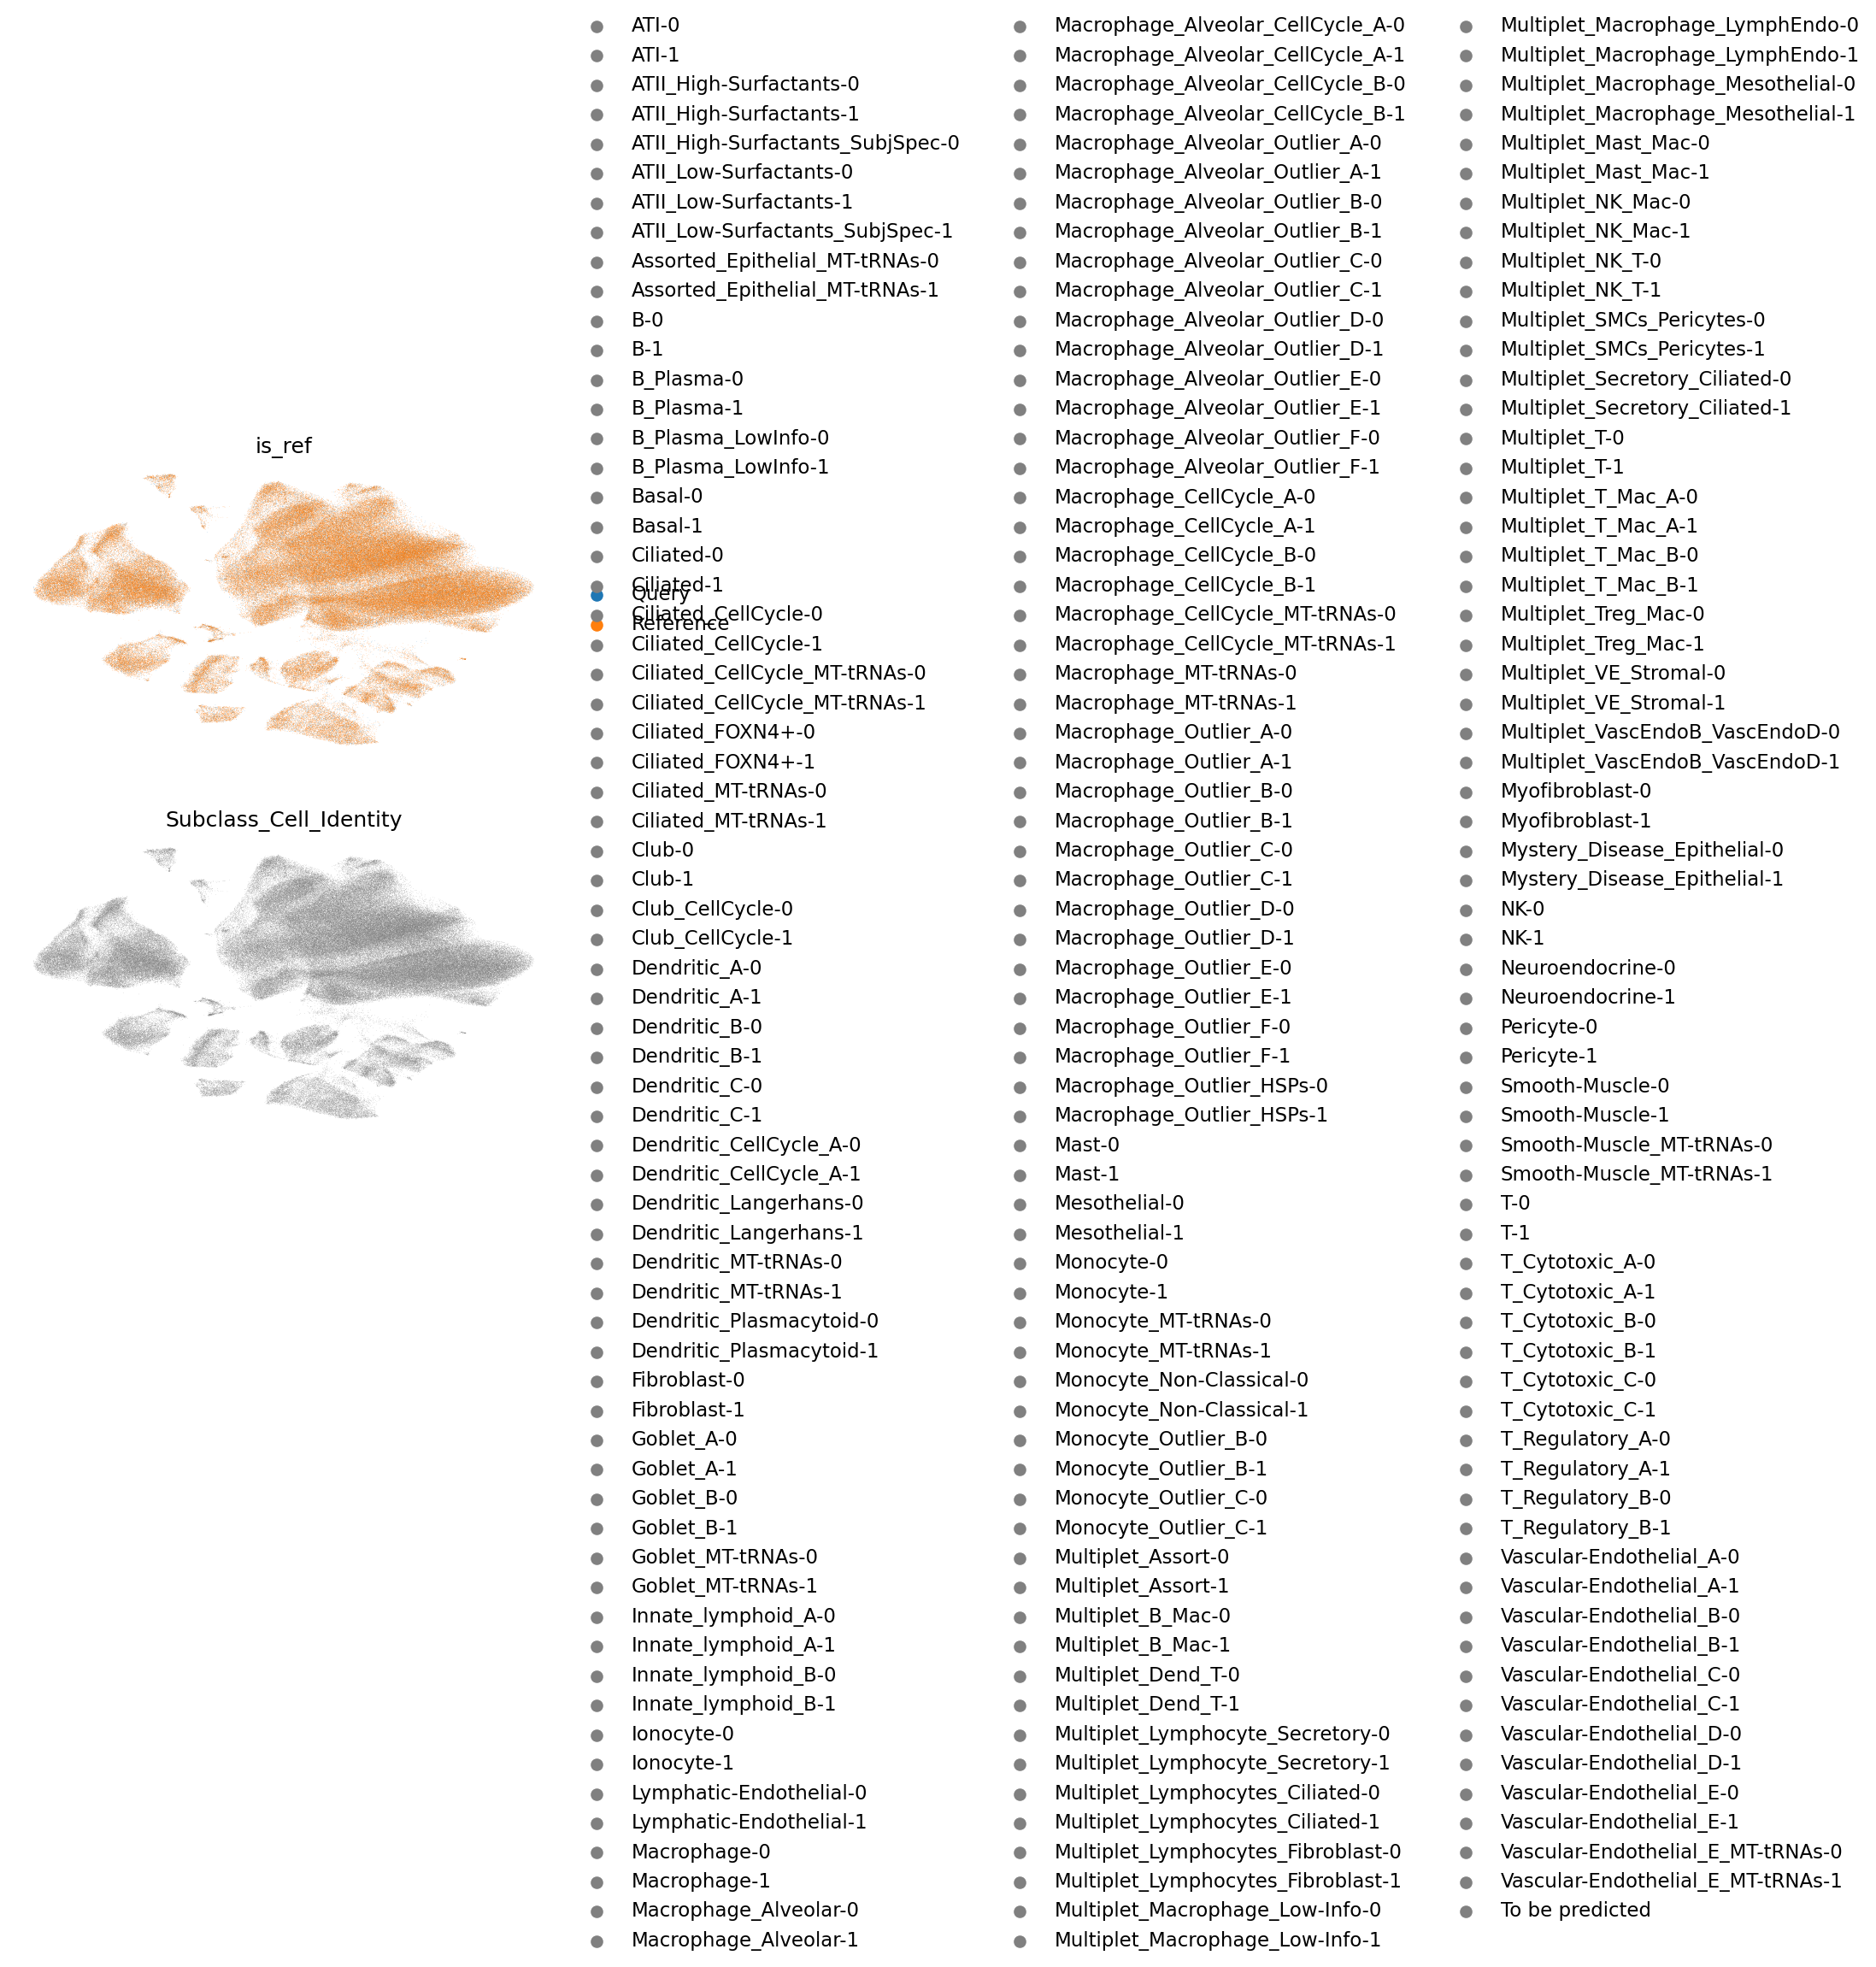

In [13]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [ ]:
sc.pp.neighbors(adata_concat_lung, use_rep="X_scGPT")
sc.tl.umap(adata_concat_lung)
sc.pl.umap(
    adata_concat_lung, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [ ]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)

        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

Determine query cell predictions using the scGPT human model

In [16]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# # Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

ref_embed_adata.obs.reset_index(inplace=True)
test_adata.obs.reset_index(inplace=True)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()

Determine query cell prediction using the scGPT lung model

In [ ]:
ref_cell_embeddings_lung = ref_embed_adata_lung.obsm["X_scGPT"]
test_emebd_lung = test_embed_adata_lung.obsm["X_scGPT"]

k = 10  # number of neighbors

index_lung = faiss.IndexFlatL2(ref_cell_embeddings_lung.shape[1])
index_lung.add(ref_cell_embeddings_lung)

# # Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances_lung, labels_lung = index_lung.search(test_emebd_lung, k)

ref_embed_adata_lung.obs.reset_index(inplace=True)

idx_list_lung = [i for i in range(test_emebd_lung.shape[0])]
preds_lung = []
sim_list_lung = distances_lung
for k in idx_list_lung:
    if faiss_imported:
        idx_lung = labels_lung[k]
    else:
        idx_lung, sim_lung = get_similar_vectors(test_emebd_lung[k][np.newaxis, ...], ref_cell_embeddings_lung, k)
    pred_lung = ref_embed_adata_lung.obs[cell_type_key][idx_lung].value_counts()
    preds_lung.append(pred_lung.index[0])
# gt_lung = test_adata_lung.obs[cell_type_key].to_numpy()

## Evaluate the performance

scGPT human

In [ ]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

scGPT lung

In [ ]:
res_dict_lung = {
    "accuracy": accuracy_score(gt, preds_lung),
    "precision": precision_score(gt, preds_lung, average="macro"),
    "recall": recall_score(gt, preds_lung, average="macro"),
    "macro_f1": f1_score(gt, preds_lung, average="macro"),
}

res_dict_lung

Confusion matrix:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'axs' is not defined

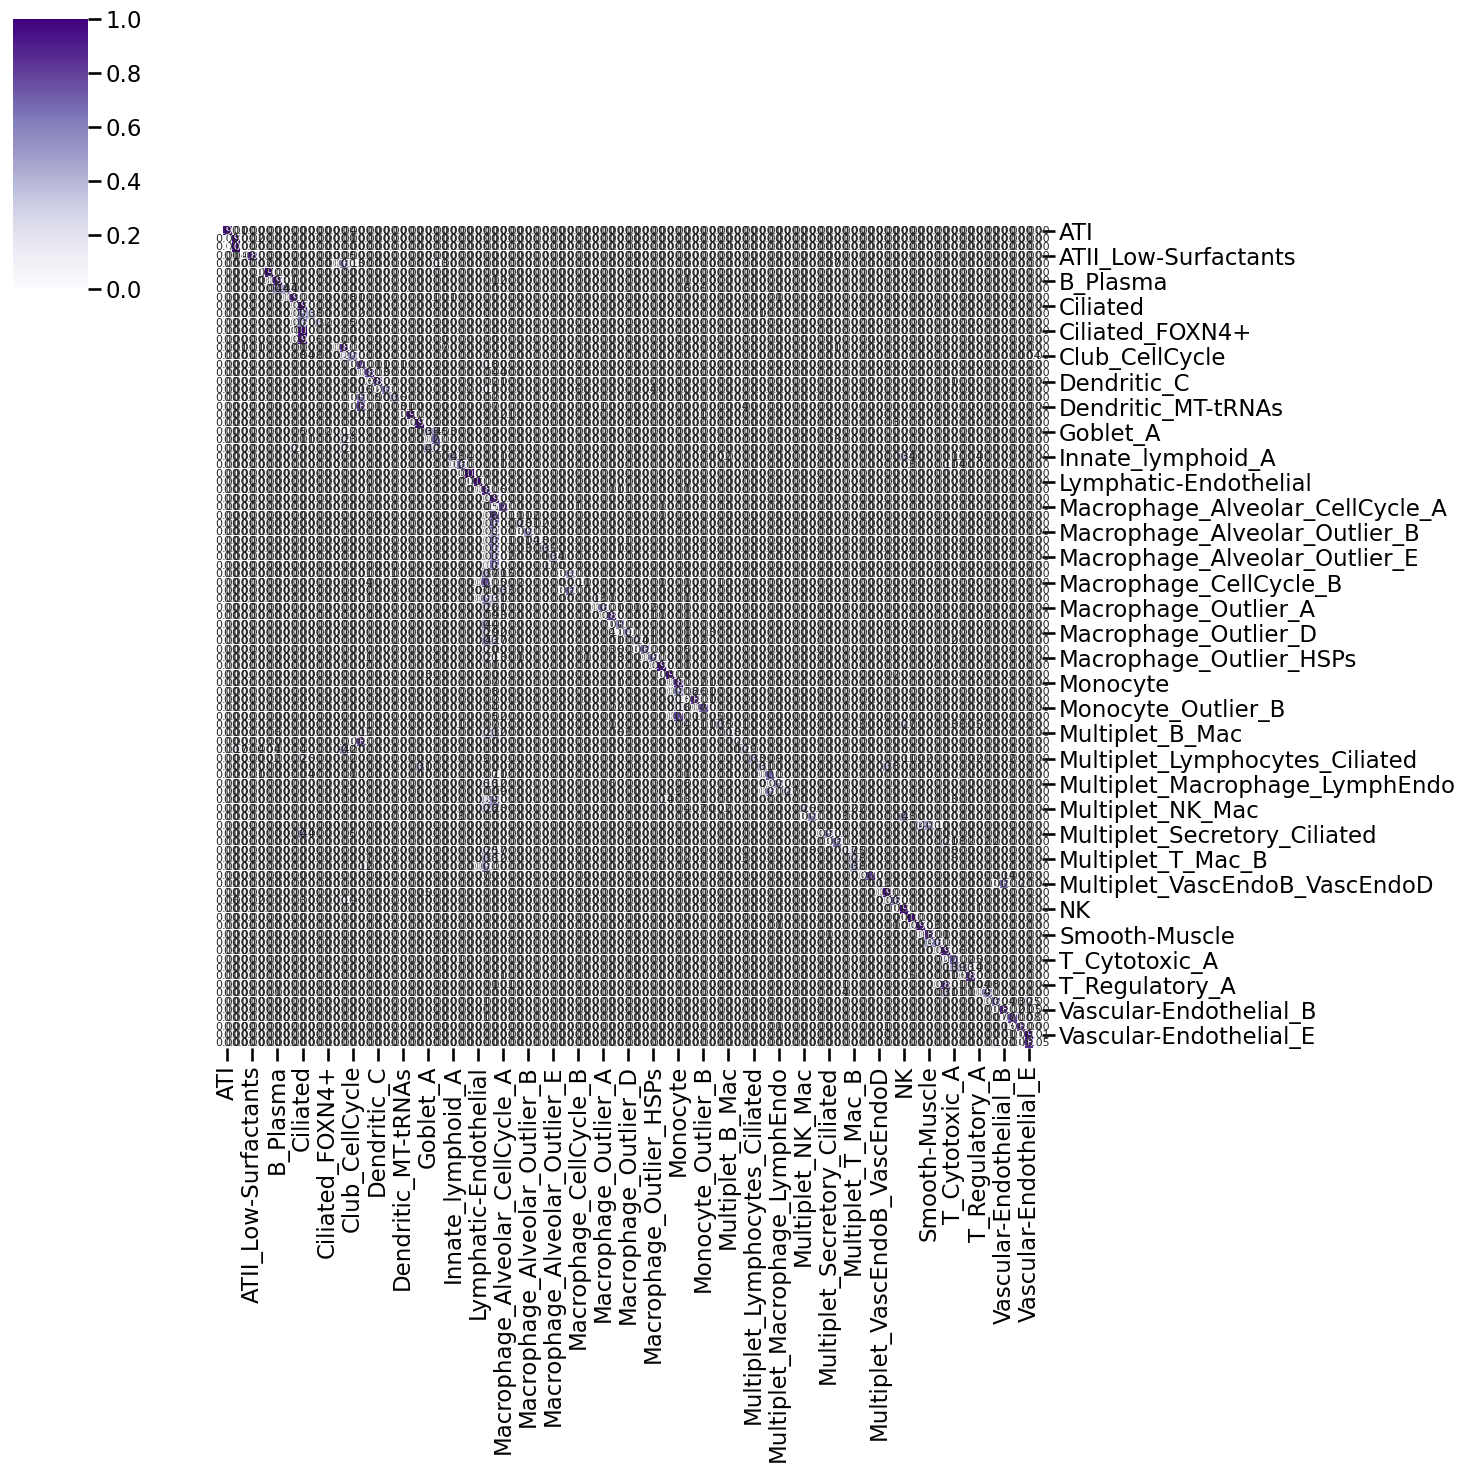

In [20]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

y_true_lung = gt
y_pred_lung = preds_lung
cell_type_list = np.unique(y_true_lung)
matrix_lung = confusion_matrix(y_true_lung, y_pred_lung, labels=cell_type_list)
matrix_lung = matrix_lung.astype("float") / matrix_lung.sum(axis=1)[:, np.newaxis]

df_lung = pd.DataFrame(matrix_lung, index=cell_type_list[:matrix_lung.shape[0]], columns=cell_type_list[:matrix_lung.shape[1]])

#fig, axs = plt.subplots(2, 2, figsize=(10, 6))


axs[0,0] = sns.clustermap(df,
                    cmap='Purples',
                    annot=True ,fmt=".2f",
                    annot_kws={'size': 8},
                    vmin=0,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    figsize=(15, 15))
axs[0,0].fig.suptitle('scGPT human')

axs[0,1] = sns.clustermap(df_lung,
                    cmap='Purples',
                    annot=True ,fmt=".2f",
                    annot_kws={'size': 8},
                    vmin=0,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    figsize=(15, 15))
axs[0,1].fig.suptitle('scGPT lung')
plt.show()